In [2]:
import cv2
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
pd.set_option('display.max_columns', 500)
import sys, os
from sklearn.linear_model import LogisticRegression
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

In [3]:
tf.random.set_seed(42)

In [4]:
from derm7pt.dataset import Derm7PtDataset, Derm7PtDatasetGroupInfrequent
from derm7pt.vis import plot_confusion
from derm7pt.kerasutils import deep_features

In [5]:
# CHANGE THIS LINE TO YOUR DATA DIRECTORY.
dir_release = "D:/COLLEGE/PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0"
dir_meta = os.path.join(dir_release, 'meta')
dir_images = os.path.join(dir_release, 'images')

In [6]:
meta_df = pd.read_csv(os.path.join(dir_meta, 'meta.csv'))
train_indexes = list(pd.read_csv(os.path.join(dir_meta, 'train_indexes.csv'))['indexes'])
valid_indexes = list(pd.read_csv(os.path.join(dir_meta, 'valid_indexes.csv'))['indexes'])
test_indexes = list(pd.read_csv(os.path.join(dir_meta, 'test_indexes.csv'))['indexes'])

In [7]:
# The full dataset before any grouping of the labels.
derm_data = Derm7PtDataset(dir_images=dir_images, 
                        metadata_df=meta_df.copy(), # Copy as is modified.
                        train_indexes=train_indexes, valid_indexes=valid_indexes, 
                        test_indexes=test_indexes)

# The dataset after grouping infrequent labels.
derm_data_group = Derm7PtDatasetGroupInfrequent(dir_images=dir_images, 
                                             metadata_df=meta_df.copy(), # Copy as is modified.
                                             train_indexes=train_indexes, 
                                             valid_indexes=valid_indexes, 
                                             test_indexes=test_indexes)

In [8]:
derm_data.dataset_stats()

Number of cases: 1011
Number of cases to train: 413
Number of cases to validate: 203
Number of cases to test: 395


In [9]:
derm_data.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 27 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   case_num                        1011 non-null   int64 
 1   diagnosis                       1011 non-null   object
 2   seven_point_score               1011 non-null   int64 
 3   pigment_network                 1011 non-null   object
 4   streaks                         1011 non-null   object
 5   pigmentation                    1011 non-null   object
 6   regression_structures           1011 non-null   object
 7   dots_and_globules               1011 non-null   object
 8   blue_whitish_veil               1011 non-null   object
 9   vascular_structures             1011 non-null   object
 10  level_of_diagnostic_difficulty  1011 non-null   object
 11  elevation                       1011 non-null   object
 12  location                        1011 non-null   

Similar medical interpretation labels are grouped together.
- in term derm_data.df, only different types of melanoma are grouped together under the abbrev MEL
- in derm_data_group.df, other DIAGNOSIS are also grouped.
- 7 point checkpoints are grouped in derm_data_group BUT not in derm_data.

In [10]:
# Converted the meta-data to categorical (*_numeric) labels.
derm_data_group.df.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes,diagnosis_numeric,pigment_network_numeric,blue_whitish_veil_numeric,vascular_structures_numeric,pigmentation_numeric,streaks_numeric,dots_and_globules_numeric,regression_structures_numeric
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN,0,0,0,1,0,0,0,0
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN,0,0,0,0,0,0,2,0
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN,0,0,0,1,0,0,2,0
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN,0,0,1,1,0,0,2,1
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN,0,0,0,0,2,0,0,0


In [11]:
train_meta = pd.read_csv('train_meta.csv')
valid_meta = pd.read_csv('valid_meta.csv')
test_meta = pd.read_csv('test_meta.csv')

In [12]:
train_meta.shape, test_meta.shape, valid_meta.shape

((413, 14), (395, 14), (203, 14))

In [13]:
# Get the dermatology and clinic training images and corresponding labels.
train_derm_paths = derm_data_group.get_img_paths(data_type='train', img_type='derm')
train_clinic_paths = derm_data_group.get_img_paths(data_type='train', img_type='clinic')
train_labels = derm_data_group.get_labels(data_type='train', one_hot=False)

# The 8 abbreviations that indicate the different types of categories 
# i.e., 1 diagnosis + 7 critera.
print(train_labels.keys())

dict_keys(['DIAG', 'PN', 'BWV', 'VS', 'PIG', 'STR', 'DaG', 'RS'])


In [14]:
# Get the dermatology and clinic test images and corresponding labels.
test_derm_paths = derm_data_group.get_img_paths(data_type='test', img_type='derm')
test_clinic_paths = derm_data_group.get_img_paths(data_type='test', img_type='clinic')
test_labels = derm_data_group.get_labels(data_type='test', one_hot=False)

In [15]:
# Note, you can get images for validation by:
valid_derm_paths = derm_data_group.get_img_paths(data_type='valid', img_type='derm')
valid_clinic_paths = derm_data_group.get_img_paths(data_type='valid', img_type='clinic')
valid_labels = derm_data_group.get_labels(data_type='valid', one_hot=False)
print(len(valid_derm_paths))
# We don't use them within this demo, but they could/should be used when choosing hyper-parameters.

203


### Transfer learning

In [16]:
# Choose a pretrained model to extract features from.
# Can use any model. Just have to make sure the input_shape is appropriate.
import tensorflow as tf
# from keras.applications.mobilenet import preprocess_input
# from keras.applications.mobilenet_v2 import MobileNetV2
# from tensorflow.keras.applications.resnet50 import preprocess_input
# from tensorflow.keras.applications.resnet_v2 import ResNet50V2
# from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from tensorflow.keras.applications.efficientnet import EfficientNetB4, preprocess_input
input_shape = (512, 512, 3)
# model = MobileNetV2(include_top=False, input_shape=input_shape)
model = EfficientNetB4(include_top=False, input_shape=input_shape, weights = 'imagenet')

In [17]:
model.summary()

Model: "efficientnetb4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 512, 512, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 512, 512, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 rescaling_1 (Rescaling)        (None, 512, 512, 3)  0           ['normalization[0][0

In [18]:
# Apply cropping around the boundary of the images to get rid of the black boundary.
crop_amount= 25

<h2>Extract features from dermatology images</h2>

In [19]:
# Extract features from training images (might take a few minutes... ideally you have a GPU.)
train_derm_f = deep_features(img_paths=train_derm_paths, model=model, 
                             func_preprocess_input=preprocess_input, 
                             target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 61ms/step


In [20]:
valid_derm_f = deep_features(img_paths=valid_derm_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 81ms/step


In [21]:
# Extract features from testing images (might take a few minutes)
test_derm_f = deep_features(img_paths=test_derm_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

1/1 [==============================] - 0s 53ms/step


In [22]:
# Number_of_images x number_of_features 
print(train_derm_f.shape) # 413 images. 
print(test_derm_f.shape) # 395 images.

(413, 1792)
(395, 1792)


<h2>Extract features from clinical images</h2>

In [23]:
# # May take a bit of time.
train_clinic_f = deep_features(img_paths=train_clinic_paths, model=model, 
                               func_preprocess_input=preprocess_input, 
                               target_size=input_shape, crop_amount=crop_amount)

valid_clinic_f = deep_features(img_paths=valid_clinic_paths, model=model, 
                            func_preprocess_input=preprocess_input, 
                            target_size=input_shape, crop_amount=crop_amount)

test_clinic_f = deep_features(img_paths=test_clinic_paths, model=model, 
                              func_preprocess_input=preprocess_input, 
                              target_size=input_shape, crop_amount=crop_amount)


1/1 [==============================] - 0s 66ms/step


In [24]:
# print(train_derm_f.shape)
# print(valid_derm_f.shape)
# print(test_derm_f.shape)

### START--- (using deep_features())

In [25]:
idx_to_class = {
    0: 'BCC', 1: 'NEV', 2: 'MEL', 3: 'MISC', 4: 'SK'
}

In [26]:
class_to_idx = {
    'BCC': 0, 'NEV': 1, 'MEL': 2, 'MISC': 3, 'SK': 4
}

In [27]:
train_meta, test_meta, valid_meta = np.array(train_meta), np.array(test_meta), np.array(valid_meta)

In [28]:
one = train_derm_f.copy()
two = valid_derm_f.copy()
three = test_derm_f.copy()

In [29]:
one.shape

(413, 1792)

In [30]:
# train_derm_f = one.copy()
# valid_derm_f = two.copy()
# test_derm_f = three.copy()

concatenating derm + clinic + meta

In [31]:
train_derm_f = np.concatenate((train_derm_f, train_meta), axis=1)
valid_derm_f = np.concatenate((valid_derm_f, valid_meta), axis=1)
test_derm_f = np.concatenate((test_derm_f, test_meta), axis=1)

In [32]:
train_derm_f.shape

(413, 1806)

In [33]:
def plot_history(history):
    # Plotting accuracy values of the train and validation sets
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

    # Plotting loss values of the train and validation sets
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    plt.show()

In [34]:
ip_shape = (train_derm_f.shape[1], )
ip_shape

(1806,)

##### A NEW MODEL FOR ALL 8 OUTPUTS (TESTING ONLY)

In [35]:
for key in train_labels.keys():
    print(key, train_labels[key].unique().shape)

DIAG (5,)
PN (3,)
BWV (2,)
VS (3,)
PIG (3,)
STR (3,)
DaG (3,)
RS (2,)


In [36]:
# tf.keras.layers.Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(l2_strength)) 

In [37]:
inputs = tf.keras.layers.Input(shape = ip_shape)
temp = tf.keras.layers.Dense(128, activation='relu')(inputs)
temp = tf.keras.layers.Dense(128, activation='relu')(temp)
temp = tf.keras.layers.Dropout(0.5)(temp)
# temp = tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01))(temp)
# temp = tf.keras.layers.Dense(128, activation='relu')(temp)

diag = tf.keras.layers.Dense(5, activation = 'softmax', name='DIAG')(temp)
pn = tf.keras.layers.Dense(3, activation = 'softmax', name='PN')(temp)
bwv = tf.keras.layers.Dense(2, activation = 'softmax', name='BWV')(temp)
vs = tf.keras.layers.Dense(3, activation = 'softmax', name='VS')(temp)
pig = tf.keras.layers.Dense(3, activation = 'softmax', name='PIG')(temp)
strr = tf.keras.layers.Dense(3, activation = 'softmax', name='STR')(temp)
dag = tf.keras.layers.Dense(3, activation = 'softmax', name='DaG')(temp)
rs = tf.keras.layers.Dense(2, activation = 'softmax', name='RS')(temp)

mm = tf.keras.models.Model(inputs = inputs, outputs = [diag, pn, bwv, vs, pig, strr, dag, rs])

In [38]:
# mm = tf.keras.Sequential([
#     tf.keras.layers.Flatten(input_shape=ip_shape),
#     # tf.keras.layers.Dense(1024, activation='relu'),
#     # tf.keras.layers.Dense(1024, activation='relu'),
#     # tf.keras.layers.Dense(1024, activation='relu'),
#     # tf.keras.layers.Dense(8, activation='relu'),
#     # tf.keras.layers.Dense(16, activation=tf.keras.layers.LeakyReLU()),
#     tf.keras.layers.Dropout(0.4),
#     # tf.keras.layers.Dense(64, activation='relu'),
#     # tf.keras.layers.Dense(128, activation='relu'),
#     # tf.keras.layers.Dense(128, activation='relu'),
#     # tf.keras.layers.Dense(512, activation='relu'),
#     # tf.keras.layers.Dense(512, activation='relu'),
#     # tf.keras.layers.Dense(512, activation='relu'),
#     tf.keras.layers.Dense(5)
# ])

In [39]:
mm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1806)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          231296      ['input_2[0][0]']                
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dense[0][0]']                  
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense_1[0][0]']                
                                                                                              

In [40]:
mm.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [41]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

In [40]:
history = mm.fit(train_derm_f, train_labels, validation_data = (valid_derm_f, valid_labels), epochs=100, callbacks=[callback])


Epoch 1/100


c:\Python39\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 [==============================] - 6s 121ms/step - loss: 7.3502 - DIAG_loss: 1.3492 - PN_loss: 1.1313 - BWV_loss: 0.5080 - VS_loss: 0.7412 - PIG_loss: 1.0075 - STR_loss: 0.8680 - DaG_loss: 1.1333 - RS_loss: 0.6117 - DIAG_accuracy: 0.4625 - PN_accuracy: 0.3995 - BWV_accuracy: 0.7942 - VS_accuracy: 0.7627 - PIG_accuracy: 0.5835 - STR_accuracy: 0.6586 - DaG_accuracy: 0.3753 - RS_accuracy: 0.7264 - val_loss: 6.8588 - val_DIAG_loss: 1.2454 - val_PN_loss: 1.0391 - val_BWV_loss: 0.5155 - val_VS_loss: 0.6271 - val_PIG_loss: 0.9571 - val_STR_loss: 0.8838 - val_DaG_loss: 1.0502 - val_RS_loss: 0.5406 - val_DIAG_accuracy: 0.4926 - val_PN_accuracy: 0.4483 - val_BWV_accuracy: 0.7734 - val_VS_accuracy: 0.8030 - val_PIG_accuracy: 0.5517 - val_STR_accuracy: 0.6108 - val_DaG_accuracy: 0.4581 - val_RS_accuracy: 0.7488
Epoch 2/100
13/13 [==============================] - 0s 32ms/step - loss: 6.3516 - DIAG_loss: 1.0383 - PN_loss: 1.0088 - BWV_loss: 0.4667 - VS_loss: 0.5669 - PIG_loss: 0.8846 - STR_lo

In [41]:
# history = mm.fit(train_derm_f, train_labels['DIAG'], validation_data = (valid_derm_f, valid_labels['DIAG']), epochs=100, callbacks=[callback])

In [42]:
# plot_history(history)


In [44]:
ls = mm.evaluate(test_derm_f, test_labels, verbose=2)

# print('\nTest accuracy:', test_acc)

c:\Python39\lib\site-packages\keras\backend.py:5582: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


13/13 - 2s - loss: 7.8869 - DIAG_loss: 1.1392 - PN_loss: 1.0992 - BWV_loss: 0.5389 - VS_loss: 0.8852 - PIG_loss: 1.0646 - STR_loss: 0.9463 - DaG_loss: 1.4343 - RS_loss: 0.7791 - DIAG_accuracy: 0.6532 - PN_accuracy: 0.6582 - BWV_accuracy: 0.8481 - VS_accuracy: 0.7924 - PIG_accuracy: 0.6430 - STR_accuracy: 0.7114 - DaG_accuracy: 0.5291 - RS_accuracy: 0.7494 - 2s/epoch - 126ms/step


In [45]:
all_acc = ls[9:]

In [46]:
print("Average accuracy for all 8 outputs:, ", sum(all_acc)/8)

Average accuracy for all 8 outputs:,  0.6981012746691704


In [46]:
# mm.save('INPUT_derm_meta_OUTPUT_8classes_MODEL_EFB4_ACC_6981.h5')

In [42]:
mm = tf.keras.models.load_model('INPUT_derm_meta_OUTPUT_8classes_MODEL_EFB4_ACC_6981.h5')

In [43]:
mm.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 1806)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 128)          231296      ['input_3[0][0]']                
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                                                                  
 dense_1 (Dense)                (None, 128)          16512       ['dropout[0][0]']                
                                                                                              

In [49]:
# mm.save("weird_with_al_EFB4_point6810.h5")

In [47]:
predictions = mm.predict(test_derm_f)

13/13 [==============================] - 0s 4ms/step


In [48]:
predictions[0].shape

(395, 5)

In [49]:
test_labels['PN']

6       0
8       0
15      0
34      0
41      0
       ..
914     2
946     0
961     0
995     0
1010    0
Name: pigment_network_numeric, Length: 395, dtype: int32

In [50]:
predictions[0].shape

(395, 5)

In [51]:
############ temp
temp_predictions = predictions.copy()
temp_predictions

[array([[4.0874648e-01, 1.6982553e-03, 5.1830178e-01, 2.0847240e-02,
         5.0406188e-02],
        [7.6109744e-03, 3.3323158e-02, 2.7019306e-04, 9.5196217e-01,
         6.8334863e-03],
        [1.6943614e-01, 1.2548320e-02, 2.3576431e-01, 1.2549656e-03,
         5.8099627e-01],
        ...,
        [1.5465003e-04, 9.1824991e-01, 1.7886816e-02, 4.1438644e-03,
         5.9564676e-02],
        [3.2648758e-03, 7.8154516e-01, 2.3437936e-03, 2.0176598e-01,
         1.1080207e-02],
        [4.5242528e-03, 7.2845705e-02, 8.8717115e-01, 3.1500511e-02,
         3.9583845e-03]], dtype=float32),
 array([[9.99102473e-01, 7.34914443e-04, 1.62706463e-04],
        [9.99339879e-01, 6.53188850e-04, 6.86985777e-06],
        [9.82664049e-01, 2.67508579e-03, 1.46608353e-02],
        ...,
        [7.97856927e-01, 1.66875422e-01, 3.52676474e-02],
        [9.99399304e-01, 5.98448678e-04, 2.26722500e-06],
        [3.30071896e-02, 8.55834067e-01, 1.11158796e-01]], dtype=float32),
 array([[9.64259803e-01, 3.5

In [52]:
def softmax_calc(preds):
    return np.exp(preds)/np.exp(preds).sum(axis = 1, keepdims = True)

In [53]:
for i in range(8):
    predictions[i] = softmax_calc(predictions[i])

In [54]:
predictions[0]

array([[0.24045919, 0.16005254, 0.26829997, 0.16314693, 0.16804135],
       [0.15176581, 0.15571864, 0.15065582, 0.39021188, 0.15164785],
       [0.18947472, 0.16196299, 0.20246843, 0.16014418, 0.28594968],
       ...,
       [0.15180007, 0.38018554, 0.1545158 , 0.15240683, 0.16109176],
       [0.15614697, 0.340045  , 0.15600324, 0.1904327 , 0.15737212],
       [0.15349719, 0.16435091, 0.37104717, 0.15769432, 0.15341036]],
      dtype=float32)

In [55]:
np.argmax(predictions[0][0])

2

In [56]:
def plot_image(i, predictions_array, true_label, img):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(idx_to_class[predicted_label],
                                100*np.max(predictions_array),
                                idx_to_class[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  true_label = true_label[i]
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(5), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

### DO ~~NOT~~ RUN AFTER THIS

In [57]:
import matplotlib.image as mpimg

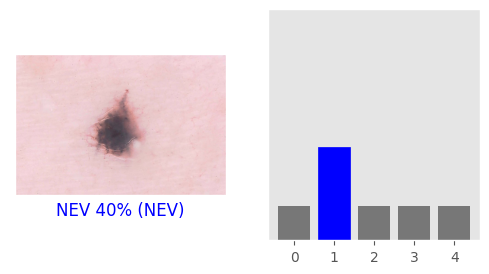

In [58]:
i = 111
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[0][i], test_labels['DIAG'].reset_index(drop = True), mpimg.imread(test_derm_paths[i]))
plt.subplot(1,2,2)
plot_value_array(i, predictions[0][i],  test_labels['DIAG'].reset_index(drop = True))
plt.show()

- 0 diag
- 1 pn
- 2 bwv
- 3 vs
- 4 pig
- 5 strr
- 6 dag
- 7 rs

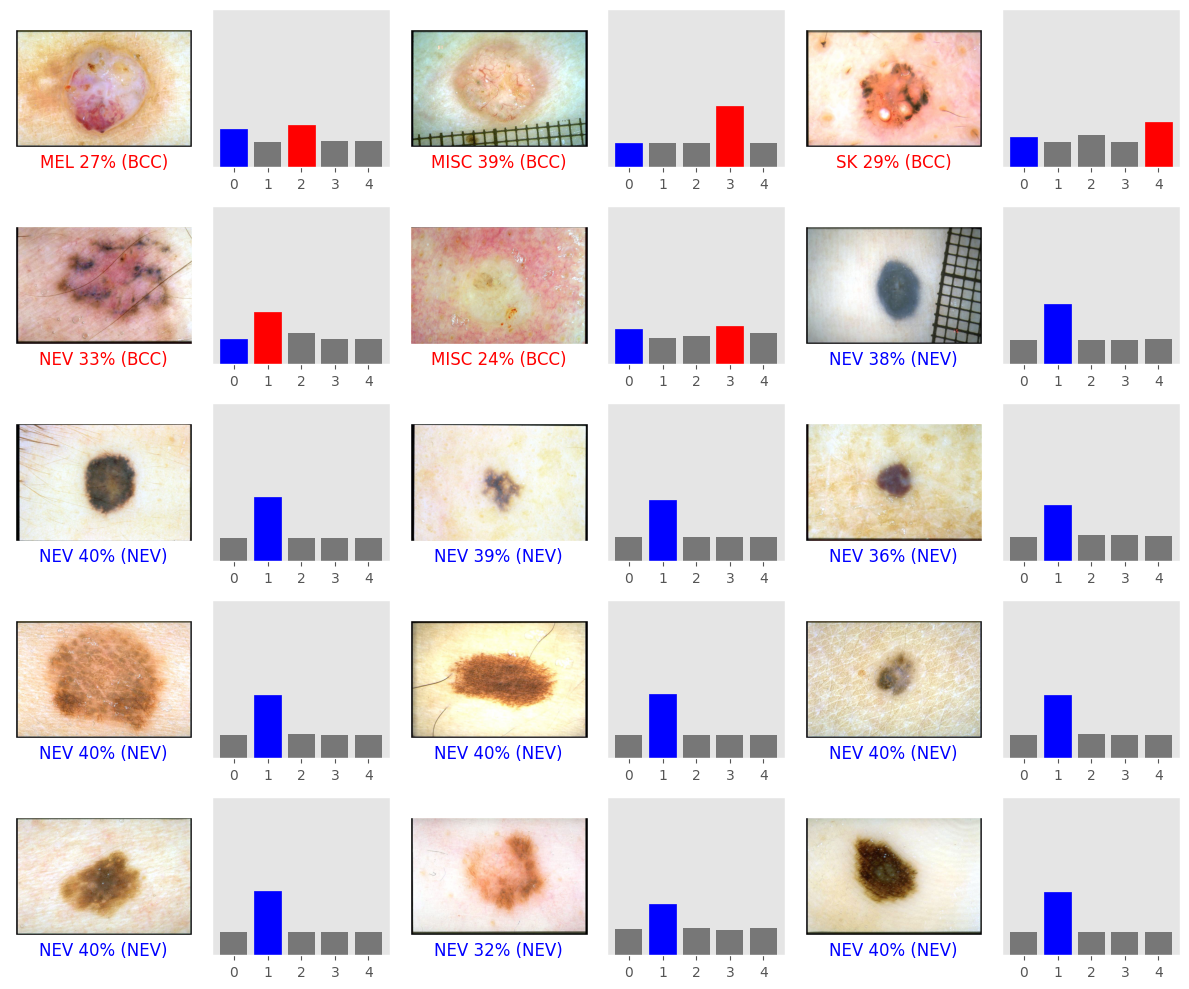

In [59]:
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[0][i], test_labels['DIAG'].reset_index(drop = True), mpimg.imread(test_derm_paths[i]))
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[0][i], test_labels['DIAG'].reset_index(drop = True))
plt.tight_layout()
plt.show()

In [60]:
test_temp = []
for i in predictions[0]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [61]:
conf_mat = np.zeros(shape=(5, 5))
for i in range(395):
    conf_mat[test_labels['DIAG'].iloc[i]][np.argmax(predictions[0][i])] += 1

conf_mat

array([[  4.,   3.,   4.,   2.,   3.],
       [  0., 198.,  13.,   8.,   0.],
       [  3.,  43.,  46.,   8.,   1.],
       [  2.,  22.,   5.,   9.,   2.],
       [  2.,  11.,   4.,   1.,   1.]])

In [62]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [63]:
def spec(conf_mat, num_classes):
    specificity = np.zeros(shape = num_classes)
    senstivity = np.zeros(shape = num_classes)
    precision = np.zeros(shape = num_classes)
    ttp, ttn, ffp, ffn = 0, 0, 0, 0

    tot_sum = conf_mat.sum()
    for i in range(num_classes):
        tn = tot_sum-conf_mat.sum(axis = 1)[i]-conf_mat.sum(axis = 0)[i]+conf_mat[i][i]
        fp = conf_mat.sum(axis = 0)[i]-conf_mat[i][i]
        tp = conf_mat[i][i]
        fn = conf_mat.sum(axis = 1)[i]-conf_mat[i][i]
        ttp += tp
        ttn += tn
        ffp += fp
        ffn += fn
        specificity[i] = tn/(fp+tn)
        precision[i] = tp/(tp+fp)
        senstivity[i] = tp/(tp+fn)

    # print(ttp, ttn, ffp, ffn)
        # print(tn, fp, specificity[i])
    print("specificity: ", specificity)
    print("senstivity: ", senstivity)
    print("precision: ", precision)
    # return specificity, senstivity, precision
    # return specificity.mean()

In [64]:
spec(conf_mat, 5)

specificity:  [0.98153034 0.55113636 0.91156463 0.94647887 0.98404255]
senstivity:  [0.25       0.90410959 0.45544554 0.225      0.05263158]
precision:  [0.36363636 0.71480144 0.63888889 0.32142857 0.14285714]


In [65]:
label_names = derm_data_group.get_label_by_abbrev('DIAG').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


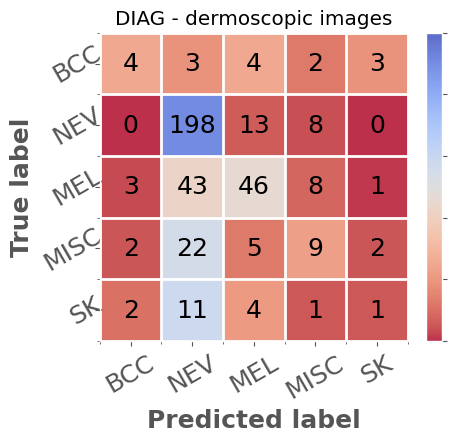

In [66]:
plot_confusion(y_true=test_labels['DIAG'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('DIAG' + ' - dermoscopic images');

In [67]:
test_temp = []
for i in predictions[1]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [68]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['PN'].iloc[i]][np.argmax(predictions[1][i])] += 1

conf_mat

array([[121.,  27.,   8.],
       [ 22., 106.,  18.],
       [ 30.,  30.,  33.]])

In [69]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [70]:
label_names = derm_data_group.get_label_by_abbrev('PN').abbrevs.values

In [71]:
spec(conf_mat, 3)

specificity:  [0.78242678 0.77108434 0.91390728]
senstivity:  [0.77564103 0.7260274  0.35483871]
precision:  [0.69942197 0.65030675 0.55932203]


d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


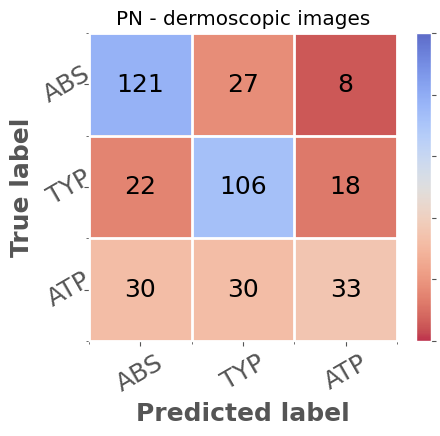

In [72]:
plot_confusion(y_true=test_labels['PN'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('PN' + ' - dermoscopic images');

In [73]:
test_temp = []
for i in predictions[2]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [74]:
conf_mat = np.zeros(shape=(2, 2))
for i in range(395):
    conf_mat[test_labels['BWV'].iloc[i]][np.argmax(predictions[2][i])] += 1

conf_mat

array([[302.,  18.],
       [ 42.,  33.]])

In [75]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [76]:
label_names = derm_data_group.get_label_by_abbrev('BWV').abbrevs.values

In [77]:
spec(conf_mat, 2)

specificity:  [0.44    0.94375]
senstivity:  [0.94375 0.44   ]
precision:  [0.87790698 0.64705882]


d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


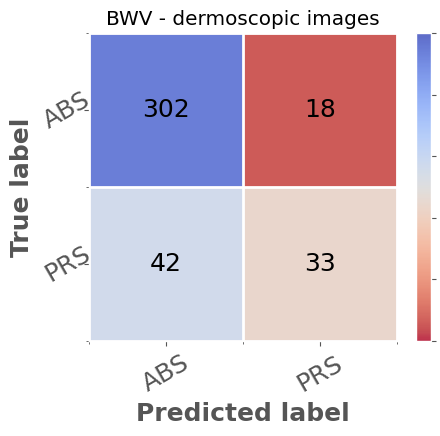

In [78]:
plot_confusion(y_true=test_labels['BWV'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('BWV' + ' - dermoscopic images');

In [79]:
test_temp = []
for i in predictions[3]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [80]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['VS'].iloc[i]][np.argmax(predictions[3][i])] += 1

conf_mat

array([[300.,  10.,   3.],
       [ 42.,   7.,   3.],
       [ 23.,   1.,   6.]])

In [81]:
spec(conf_mat, 3)

specificity:  [0.20731707 0.96793003 0.98356164]
senstivity:  [0.95846645 0.13461538 0.2       ]
precision:  [0.82191781 0.38888889 0.5       ]


In [82]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [83]:
label_names = derm_data_group.get_label_by_abbrev('VS').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


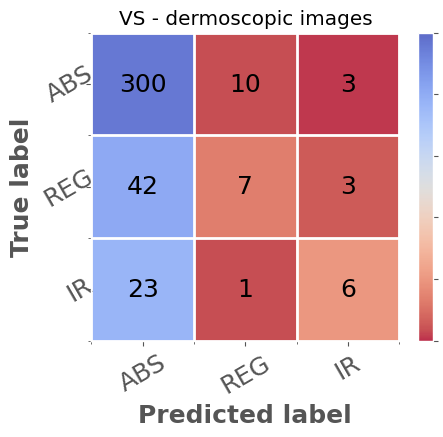

In [84]:
plot_confusion(y_true=test_labels['VS'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('VS' + ' - dermoscopic images');

In [85]:
test_temp = []
for i in predictions[4]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [86]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['PIG'].iloc[i]][np.argmax(predictions[4][i])] += 1

conf_mat

array([[191.,   4.,  28.],
       [ 29.,  13.,   6.],
       [ 72.,   2.,  50.]])

In [87]:
spec(conf_mat, 3)

specificity:  [0.4127907  0.98270893 0.87453875]
senstivity:  [0.85650224 0.27083333 0.40322581]
precision:  [0.65410959 0.68421053 0.5952381 ]


In [88]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [89]:
label_names = derm_data_group.get_label_by_abbrev('PIG').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


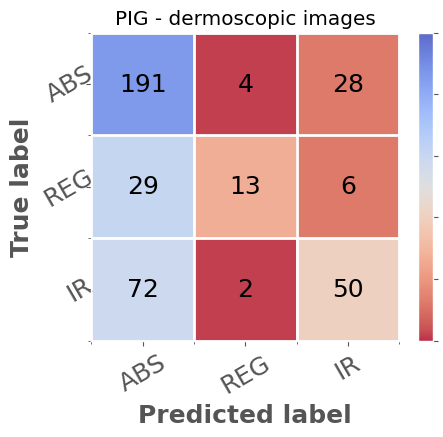

In [90]:
plot_confusion(y_true=test_labels['PIG'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('PIG' + ' - dermoscopic images');

In [91]:
test_temp = []
for i in predictions[5]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [92]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['STR'].iloc[i]][np.argmax(predictions[5][i])] += 1

conf_mat

array([[232.,   3.,  22.],
       [ 16.,  19.,   9.],
       [ 60.,   4.,  30.]])

In [93]:
spec(conf_mat, 3)

specificity:  [0.44927536 0.98005698 0.89700997]
senstivity:  [0.90272374 0.43181818 0.31914894]
precision:  [0.75324675 0.73076923 0.49180328]


In [94]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [95]:
label_names = derm_data_group.get_label_by_abbrev('STR').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


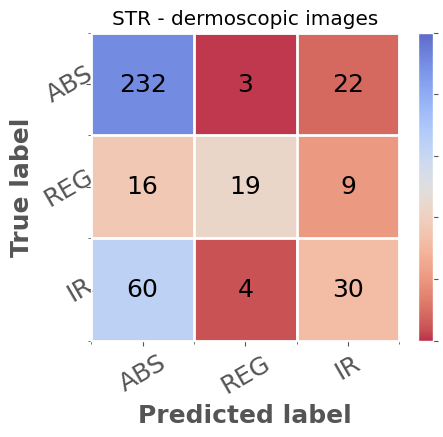

In [96]:
plot_confusion(y_true=test_labels['STR'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('STR' + ' - dermoscopic images');

In [97]:
test_temp = []
for i in predictions[6]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [98]:
conf_mat = np.zeros(shape=(3, 3))
for i in range(395):
    conf_mat[test_labels['DaG'].iloc[i]][np.argmax(predictions[6][i])] += 1

conf_mat

array([[35., 38., 27.],
       [15., 78., 25.],
       [26., 55., 96.]])

In [99]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [100]:
spec(conf_mat, 3)

specificity:  [0.86101695 0.66425993 0.76146789]
senstivity:  [0.35       0.66101695 0.54237288]
precision:  [0.46052632 0.45614035 0.64864865]


In [101]:
label_names = derm_data_group.get_label_by_abbrev('DaG').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


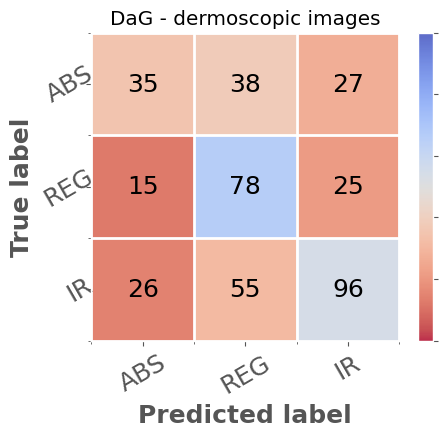

In [102]:
plot_confusion(y_true=test_labels['DaG'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('DaG' + ' - dermoscopic images');

In [103]:
test_temp = []
for i in predictions[7]:
    test_temp.append(np.argmax(i))
test_temp = np.array(test_temp)
test_temp.shape

(395,)

In [104]:
conf_mat = np.zeros(shape=(2, 2))
for i in range(395):
    conf_mat[test_labels['RS'].iloc[i]][np.argmax(predictions[7][i])] += 1

conf_mat

array([[263.,  26.],
       [ 73.,  33.]])

In [105]:
spec(conf_mat, 2)

specificity:  [0.31132075 0.9100346 ]
senstivity:  [0.9100346  0.31132075]
precision:  [0.7827381  0.55932203]


In [106]:
tot_sum = conf_mat.sum()
tot_sum

395.0

In [107]:
label_names = derm_data_group.get_label_by_abbrev('RS').abbrevs.values

d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  cb.ax.set_yticklabels(cb.ax.get_yticklabels(), fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontsize=fontsize)
d:\COLLEGE\PROJECTS\(incomplete) 7 point checklist\derm7pt\derm7pt\vis.py:37: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(labels, fontsize=fontsize)


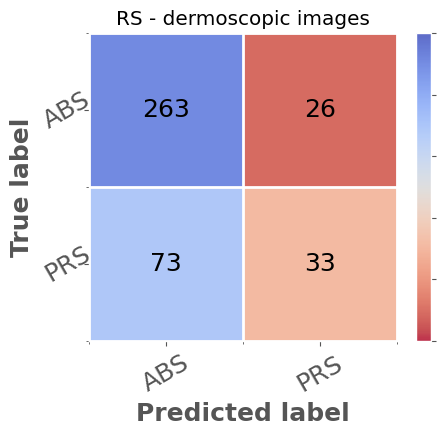

In [108]:
plot_confusion(y_true=test_labels['RS'], y_pred=test_temp, labels=label_names, figsize=(6,4))
plt.title('RS' + ' - dermoscopic images');

In [109]:
history.history.keys()

NameError: name 'history' is not defined

In [110]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

NameError: name 'history' is not defined

#### Calculating 7-point checklist score to infer presence of Melanoma

In [111]:
pigment_network = [0, 0, 2]
blue_whitish_viel = [0, 2]
vascular_structures = [0, 0, 2]
pigmentation = [0, 0, 1]
streaks = [0, 0, 1]
dots_and_globules = [0, 0, 1]
regression_structures = [0, 1]

In [112]:
test_labels.keys()

dict_keys(['DIAG', 'PN', 'BWV', 'VS', 'PIG', 'STR', 'DaG', 'RS'])

In [113]:
predictions[1][11], predictions[1][11].argmax()
sevenpt_scores = [0 for i in range(395)]
for i in range(395):
    sevenpt_scores[i] = pigment_network[predictions[1][i].argmax()]
    + blue_whitish_viel[predictions[2][i].argmax()]
    + vascular_structures[predictions[3][i].argmax()]
    + pigmentation[predictions[4][i].argmax()]
    + streaks[predictions[5][i].argmax()]
    + dots_and_globules[predictions[6][i].argmax()]
    + regression_structures[predictions[7][i].argmax()]

In [114]:
true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
for i in range(395):
    if test_labels['DIAG'].iloc[i] == 2:
        if sevenpt_scores[i] >= 1:
            true_pos += 1
        else:
            false_neg += 1
    else:
        if sevenpt_scores[i] >= 1:
            false_pos += 1
        else:
            true_neg += 1

In [115]:
true_pos, true_neg, false_pos, false_neg

(26, 261, 33, 75)

In [116]:
true_pos/(true_pos+false_pos)

0.4406779661016949

In [117]:
test_labels['DIAG'][test_labels['DIAG'] == 2].count()

101

In [118]:
datadata = pd.read_csv("D:/COLLEGE\PROJECTS/(incomplete) 7 point checklist/derm7pt/release_v0/meta/meta.csv")

In [119]:
datadata.head()

,case_num,diagnosis,seven_point_score,pigment_network,streaks,pigmentation,regression_structures,dots_and_globules,blue_whitish_veil,vascular_structures,level_of_diagnostic_difficulty,elevation,location,sex,management,clinic,derm,case_id,notes
0,1,basal cell carcinoma,0,absent,absent,absent,absent,absent,absent,arborizing,medium,nodular,abdomen,female,excision,NEL/NEL025.JPG,NEL/Nel026.jpg,NaN,NaN
1,2,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,absent,low,palpable,head neck,female,excision,NEL/NEL027.JPG,NEL/Nel028.jpg,NaN,NaN
2,3,basal cell carcinoma,1,absent,absent,absent,absent,irregular,absent,arborizing,medium,palpable,head neck,female,excision,NEL/Nel032.jpg,NEL/Nel033.jpg,NaN,NaN
3,4,basal cell carcinoma,4,absent,absent,absent,blue areas,irregular,present,within regression,low,palpable,lower limbs,male,excision,NEL/NEL034.JPG,NEL/Nel035.jpg,NaN,NaN
4,5,basal cell carcinoma,1,absent,absent,diffuse irregular,absent,absent,absent,absent,high,palpable,upper limbs,female,excision,NEL/NEL036.JPG,NEL/Nel037.jpg,NaN,NaN


In [120]:
datadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1011 entries, 0 to 1010
Data columns (total 19 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   case_num                        1011 non-null   int64 
 1   diagnosis                       1011 non-null   object
 2   seven_point_score               1011 non-null   int64 
 3   pigment_network                 1011 non-null   object
 4   streaks                         1011 non-null   object
 5   pigmentation                    1011 non-null   object
 6   regression_structures           1011 non-null   object
 7   dots_and_globules               1011 non-null   object
 8   blue_whitish_veil               1011 non-null   object
 9   vascular_structures             1011 non-null   object
 10  level_of_diagnostic_difficulty  1011 non-null   object
 11  elevation                       1011 non-null   object
 12  location                        1011 non-null   

In [121]:
datadata.management.unique()

array(['excision', 'no further examination', 'clinical follow up'],
      dtype=object)

In [122]:
datadata[['diagnosis', 'seven_point_score', 'elevation', 'location', 'sex', 'management']].head()

,diagnosis,seven_point_score,elevation,location,sex,management
0,basal cell carcinoma,0,nodular,abdomen,female,excision
1,basal cell carcinoma,1,palpable,head neck,female,excision
2,basal cell carcinoma,1,palpable,head neck,female,excision
3,basal cell carcinoma,4,palpable,lower limbs,male,excision
4,basal cell carcinoma,1,palpable,upper limbs,female,excision
